# Solving 2D Inverse Poisson Equation using Physics-Informed Neural Networks (PINNs)

## Introduction

In this tutorial, we will solve the inverse Poisson equation on a square domain $[0,1]^2$.

The problem can be described as:

$-\epsilon \Delta u = f(x, y)$

where:
* $\epsilon $ is the diffusion coefficient.
* $u(x, y)$ is the known solution field.
* $f(x, y)$ is a known source function.

The objective is to predict the constant diffusion parameter, denoted as $\epsilon$, and the corresponding solution $u(x, y)$ that satisfies the given equation within the domain.

For this problem we are taking 
$$f(x,y) = \sin(x)\tanh(x) \times e^{-\epsilon x^2} \times 10$$
with $\epsilon = 0.3$


## 1. Importing the required libraries

In [1]:
# --- IMPORTS ---
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 

2024-12-14 00:13:52.028322: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-14 00:13:52.574938: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# --- CONFIGURABLE PARAMETERS ---
# Domain boundaries
x_min, x_max = 0.0, 1.0  # x-coordinate bounds
y_min, y_max = 0.0, 1.0  # y-coordinate bounds

# Neural network architecture and training parameters
layers = [2, 30, 30, 30, 30, 1]  # Network architecture: [input_dim, hidden_dim, output_dim]
lr_initial = 0.01    # Initial learning rate for Adam optimizer
epochs = 5000       # Number of training epochs
alpha = 10
beta = 10          # Weight for boundary condition loss term
eps_initial = 2

# Sampling parameters
N_interior = 10000    # Number of interior training points
N_boundary = 800     # Number of boundary training points
N_test = 2500     # Number of boundary test points
N_sensor = 1000

In [3]:
def set_device():
    """
    Configure and select the computational device (GPU/CPU).
    
    Returns:
        str: Device identifier ('/GPU:0' or '/CPU:0')
    """
    gpus = tf.config.list_physical_devices('GPU')
    if gpus:
        print("Using GPU")
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        return '/GPU:0'
    print("Using CPU")
    return '/CPU:0'

In [4]:
device = set_device()  

Using GPU


2024-12-14 00:13:55.545675: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-12-14 00:13:55.570951: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-12-14 00:13:55.571217: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

## 2. Generate Training Points

We'll generate three sets of points to train our Physics-Informed Neural Network:

1. **Boundary Points**: These points lie on the edges of our domain $[0,1]^2$
2. **Interior Points**: These points fill the inside of our domain
   * Used to enforce the PDE. 
3. **Sensor Points**: These points are where observations of $u(x, y)$ are available.   



In [5]:
def generate_boundary_points(xmin, xmax, ymin, ymax, num_points):
    """
    Generate training points along the domain boundaries.
    
    Args:
        xmin, xmax (float): x-coordinate bounds
        ymin, ymax (float): y-coordinate bounds
        num_points (int): Total number of boundary points to generate
    
    Returns:
        tuple: Arrays of x and y coordinates for boundary points
    """
    num_per_edge = num_points // 4
    # Generate points for each boundary edge
    bottom = np.column_stack((np.linspace(x_min, x_max, num_per_edge), np.full((num_per_edge,), y_min)))
    right = np.column_stack((np.full((num_per_edge,), x_max), np.linspace(y_min, y_max, num_per_edge)))
    top = np.column_stack((np.linspace(x_min, x_max, num_per_edge), np.full((num_per_edge,), y_max)))
    left = np.column_stack((np.full((num_per_edge,), x_min), np.linspace(y_min, y_max, num_per_edge)))
    boundary_pt = np.row_stack((bottom, right, top, left))
    return boundary_pt

In [6]:
def generate_interior_points(xmin, xmax, ymin, ymax, num_points):
    """
    Generate training points along the domain boundaries.
    
    Args:
        xmin, xmax (float): x-coordinate bounds
        ymin, ymax (float): y-coordinate bounds
        num_points (int): Total number of boundary points to generate
    
    Returns:
        tuple: Arrays of x and y coordinates for boundary points
    """
    x_train_interior = np.random.uniform(x_min, x_max, (N_interior, 1))
    y_train_interior = np.random.uniform(y_min, y_max, (N_interior, 1))
    interior_pt = np.column_stack((x_train_interior, y_train_interior))
    return interior_pt

In [7]:
def generate_sensor_points(xmin, xmax, ymin, ymax, num_sensor):
    """

    Args:
        xmin, xmax (float): x-coordinate bounds
        ymin, ymax (float): y-coordinate bounds
        num_points (int): Total number of sensor points to generate


    Returns:
        tuple: Arrays of x and y coordinates for sensor points

    """    
    
    x_sensor = np.random.uniform(xmin, xmax, num_sensor)
    y_sensor = np.random.uniform(ymin, ymax, num_sensor)
    sensor_pt = np.column_stack((x_sensor, y_sensor))
    return sensor_pt

In [8]:
def generate_test_points(xmin, xmax, ymin, ymax, num_points):

    """
    Generate test points for evaluating the solution.

     Args:
        xmin, xmax (float): x-coordinate bounds
        ymin, ymax (float): y-coordinate bounds
        num_points (int): Total number of test points to generate
    
    Returns:
        tuple: Arrays of x and y coordinates for test points
    """
    
    num = int(np.sqrt(num_points))
    x_test = np.linspace(xmin, xmax, num)
    y_test = np.linspace(ymin, ymax, num)
    X_test, Y_test = np.meshgrid(x_test, y_test)
    test_pt = np.column_stack((X_test.flatten(), Y_test.flatten()))
    return test_pt

# 3. Exact solution :

In [9]:
def analytical_solution_inverse(points, eps = 0.3):
    """
    Analytical solution for the inverse problem using TensorFlow functions.
    Args:
        x, y: spatial coordinates in [0,1]²
        epsilon: diffusion coefficient
    Returns:
        u: exact solution
    """
    x = tf.expand_dims(points[:,0], axis = 1)
    val = tf.sin(x) * tf.tanh(x) * tf.exp(-1.0 * eps * (x**2)) * 10
    return val

## 4. Boundary condition :

In [10]:
def u_bc(points, eps = 0.3):
    """
    Define the Dirichlet boundary condition.
    
    Args:
        x (tf.Tensor): (x,y)-coordinates of boundary points
    
    Returns:
        tf.Tensor: Boundary values (zero in this case)
    """
    val = analytical_solution_inverse(points, eps)
    return val

In [11]:
def generate_sensor_data(points, eps = 0.3):
    """
    Generate sensor data for the inverse problem.

    Args:
        points: sensor points
        epsilon: diffusion coefficient
    Returns:
        measurements: sensor data
    """
    measurements = analytical_solution_inverse(points, eps)
    return measurements

## 4. Source Function:
  * Right-hand side of the Poisson equation 
 


In [12]:
# @tf.function
def f(points, eps):
    """
    Define the forcing function for the PDE.
    
    Args:
        x (tf.Tensor): x-coordinates
        y (tf.Tensor): y-coordinates
    
    Returns:
        tf.Tensor: Values of the forcing function at given points
    """
    x = tf.expand_dims(points[:,0], axis = 1)
    val = -eps* (
            40.0 * x * eps * (tf.tanh(x) ** 2 - 1) * tf.sin(x)
            - 40.0 * x * eps * tf.cos(x) * tf.tanh(x)
            + 10 * eps * (4.0 * x**2 * eps - 2.0) * tf.sin(x) * tf.tanh(x)
            + 20 * (tf.tanh(x) ** 2 - 1) * tf.sin(x) * tf.tanh(x)
            - 20 * (tf.tanh(x) ** 2 - 1) * tf.cos(x)
            - 10 * tf.sin(x) * tf.tanh(x)
        )* tf.exp(-1.0 * x**2 * eps)
    return val

 # 5. PDE Residual, Boundary loss and Sensor loss :

In [13]:
# @tf.function
def pde_loss_fn(model, train_interior, eps):
    """
    Calculate the PDE residual loss using automatic differentiation.
    
    Args:
        model (tf.keras.Model): Neural network model
        train_interior (tf.Tensor): Interior training points
        eps (float): Diffusion coefficient
    
    Returns:
        tf.Tensor: Mean squared PDE residual
    """
    
    # Calculate derivatives using automatic differentiation
    x = tf.expand_dims(train_interior[:,0], axis = 1)
    y = tf.expand_dims(train_interior[:,1], axis = 1)
    with tf.GradientTape(persistent= True) as tape1:
        tape1.watch(x)
        tape1.watch(y)
        with tf.GradientTape(persistent = True) as tape2:
            tape2.watch(x)
            tape2.watch(y)  
            u = model(tf.concat([x,y], axis = 1))
        grad_x = tape2.gradient(u, x)
        grad_y = tape2.gradient(u, y)
    grad_xx = tape1.gradient(grad_x, x)
    grad_yy = tape1.gradient(grad_y, y)
    del tape1
    del tape2
    residual = -eps*(grad_xx + grad_yy) - f(train_interior, eps)
    return tf.reduce_mean(tf.square(residual))

In [14]:
# @tf.function
def bc_loss_fn(model, x_bd):
    """
    Calculate the boundary condition loss.
    
    Args:
        model (tf.keras.Model): Neural network model
        x_bd (tf.Tensor): Boundary points
    
    Returns:
        tf.Tensor: Mean squared error at boundary points
    """
    u_pred = model(x_bd)
    u_exact = u_bc(x_bd)
    return tf.reduce_mean(tf.square(u_pred - u_exact))

In [15]:
# @tf.function
def sensor_loss_fn(model, x_sensor):
    """
    Calculate the sensor data loss.
    
    Args:
        model (tf.keras.Model): Neural network model
        x_sensor (tf.Tensor): sensor points
    
    Returns:
        tf.Tensor: Mean squared error at sensor points
    """
    u_pred = model(x_sensor)
    u_exact = generate_sensor_data(x_sensor)
    return tf.reduce_mean(tf.square(u_pred - u_exact))

# 6. Training the model

In [16]:
# @tf.function
def train_step(model, optimizer, train_interior, train_boundary, train_sensor, eps, alpha, beta):
    """
    Train the PINN model.
    
    Args:
        model (tf.keras.Model): Neural network model
        optimizer (tf.keras.optimizers.Optimizer): Optimizer for model training
        train_interior (tf.Tensor): Interior training points
        train_boundary (tf.Tensor): Boundary training points
        train_sensor (tf.Tensor): Sensor training points
        eps (float): Trainable variable for diffusion coefficient
        beta (float): Weight for boundary condition loss
    """
    
        # Compute gradients and update model parameters
    with tf.GradientTape() as tape:
        loss_pde = pde_loss_fn(model, train_interior, eps)
        loss_bc = beta * bc_loss_fn(model, train_boundary)
        loss_sensor = alpha * sensor_loss_fn(model, train_sensor)
        total_loss = loss_pde + loss_sensor + loss_bc 
        
    grads = tape.gradient(total_loss, model.trainable_variables+[eps])
    optimizer.apply_gradients(zip(grads, model.trainable_variables+[eps]))
    return total_loss, loss_pde, loss_bc, loss_sensor, eps
            

In [17]:
# --- MAIN EXECUTION ---

# Generate training data
train_interior = generate_interior_points(x_min, x_max, y_min, y_max, N_interior)
train_interior = tf.convert_to_tensor(train_interior, dtype = tf.float32)

train_boundary = generate_boundary_points(x_min, x_max, y_min, y_max, N_boundary)
train_boundary = tf.convert_to_tensor(train_boundary, dtype = tf.float32)

train_sensor = generate_sensor_points(x_min, x_max, y_min, y_max, N_sensor)
train_sensor = tf.convert_to_tensor(train_sensor, dtype = tf.float32)

# Lists for storing training history
total_loss_ar = []
pde_loss_ar = []
bound_loss_ar = []
sensor_loss_ar = []
eps_ar = []

# Create and train model on specified device
with tf.device(device):
    # Define neural network architecture
    eps = tf.Variable(initial_value=eps_initial, trainable=True, dtype=tf.float32)
    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=(2,)),
        *[tf.keras.layers.Dense(units, activation='tanh') for units in layers[1:-1]],
        tf.keras.layers.Dense(1)
    ])
    optimizer = tf.optimizers.Adam(learning_rate=lr_initial)
    # Train the model
    for epoch in range(epochs):  
        total_loss, pde_loss, bound_loss, sensor_loss, eps = train_step(model, optimizer, train_interior, train_boundary, train_sensor,
                                                                         eps, alpha, beta)
        total_loss_ar.append(total_loss.numpy())
        pde_loss_ar.append(pde_loss.numpy())
        bound_loss_ar.append(bound_loss.numpy())
        sensor_loss_ar.append(sensor_loss.numpy())
        eps_ar.append(eps.numpy())
        # Print training progress inside the tf.function
        if epoch % 500 == 0 or epoch == epochs - 1:
            # Use tf.print to correctly print the values inside tf.function
            print("Epoch:", epoch, 
                    "Total Loss:", total_loss.numpy(), 
                    "PDE Loss:", pde_loss.numpy(), 
                    "BC Loss:", bound_loss.numpy(),
                    "Sensor Loss:", sensor_loss.numpy(),
                    "eps:", eps.numpy())


2024-12-14 00:14:04.123212: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-12-14 00:14:04.123476: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-12-14 00:14:04.123639: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

2024-12-14 00:14:04.639604: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:114] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



2024-12-14 00:14:05.154250: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:114] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



Epoch: 0 Total Loss: 710.06665 PDE Loss: 523.2469 BC Loss: 103.394424 Sensor Loss: 83.42538 eps: 1.9899998
Epoch: 500 Total Loss: 2.354816 PDE Loss: 0.32727605 BC Loss: 0.945191 Sensor Loss: 1.0823491 eps: 1.371199
Epoch: 1000 Total Loss: 0.7915783 PDE Loss: 0.038965072 BC Loss: 0.24622561 Sensor Loss: 0.50638765 eps: 1.0715624
Epoch: 1500 Total Loss: 0.37787712 PDE Loss: 0.025103584 BC Loss: 0.10108416 Sensor Loss: 0.25168937 eps: 0.8069368
Epoch: 2000 Total Loss: 0.0940412 PDE Loss: 0.008098451 BC Loss: 0.02565239 Sensor Loss: 0.06029036 eps: 0.5278549
Epoch: 2500 Total Loss: 0.008977471 PDE Loss: 0.0014483755 BC Loss: 0.004722323 Sensor Loss: 0.0028067732 eps: 0.35812223
Epoch: 3000 Total Loss: 0.0012774568 PDE Loss: 0.00040983863 BC Loss: 0.0005369198 Sensor Loss: 0.00033069833 eps: 0.31575444
Epoch: 3500 Total Loss: 0.0005875076 PDE Loss: 0.00027273197 BC Loss: 0.00021604827 Sensor Loss: 9.872739e-05 eps: 0.30819386
Epoch: 4000 Total Loss: 0.00035001195 PDE Loss: 0.00019208365 BC 

# 7. Plotting the losses

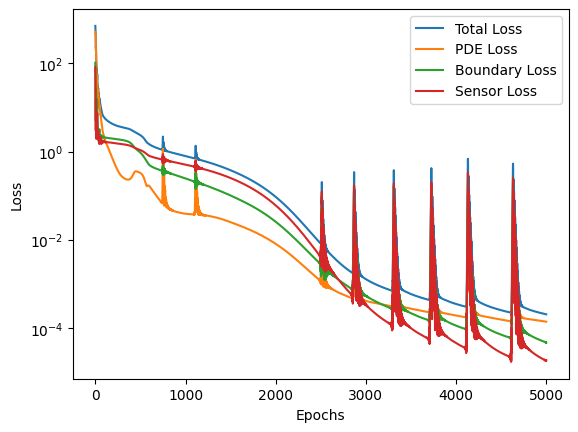

In [18]:
#plotting the total loss, pde loss and boundary loss
plt.figure()
#log scale
plt.yscale('log')
plt.plot(total_loss_ar, label = 'Total Loss')
plt.plot(pde_loss_ar, label = 'PDE Loss')
plt.plot(bound_loss_ar, label = 'Boundary Loss')
plt.plot(sensor_loss_ar, label = 'Sensor Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 8. Plot the predicted epsilon

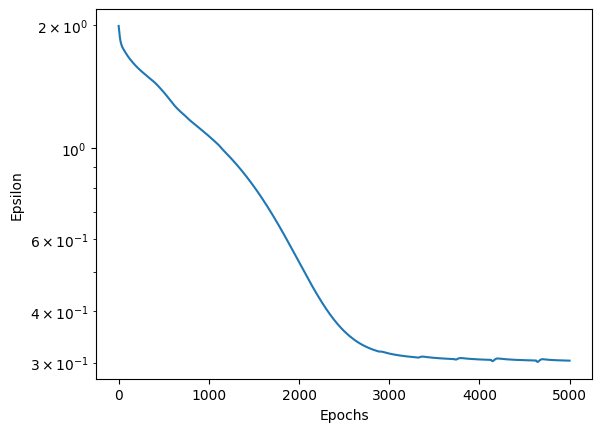

Epsilon: 0.30339667


In [19]:
#plotting the epsilon
plt.figure()
plt.plot(eps_ar)
plt.yscale('log')
plt.xlabel('Epochs')
plt.ylabel('Epsilon')
plt.show()

#printing the epsilon
print('Epsilon:', eps.numpy())


# 8. Testing the model and plotting the results

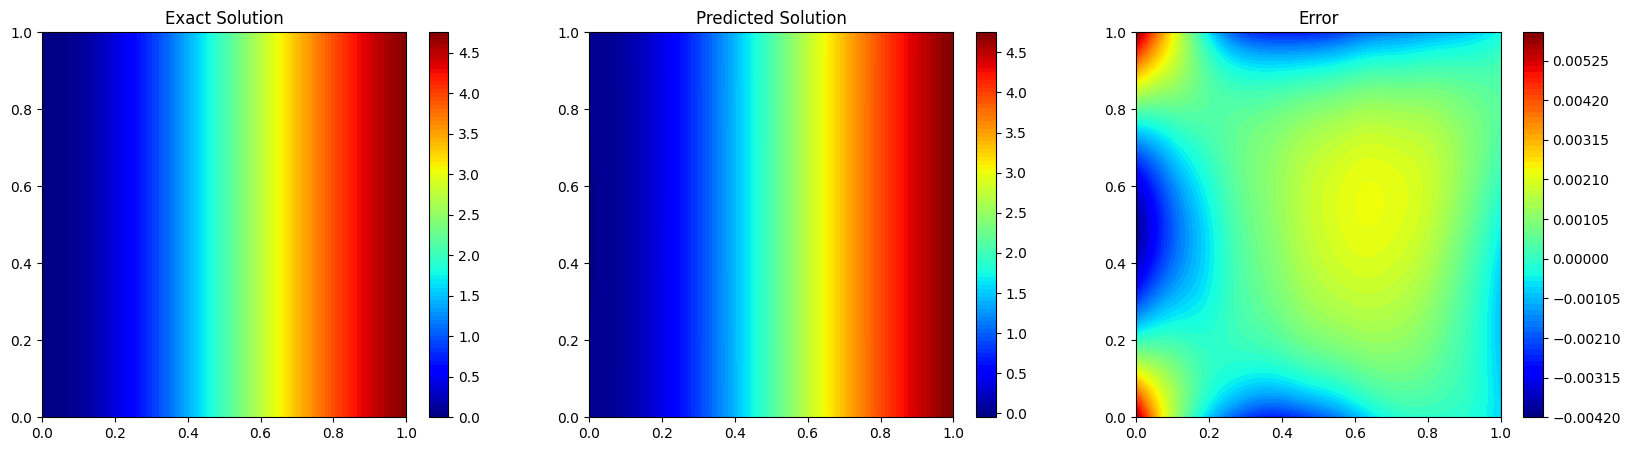

In [21]:
test_pt = generate_test_points(x_min, x_max, y_min, y_max, N_test)
test_pt = tf.convert_to_tensor(test_pt, dtype = tf.float32)
u_test = model(test_pt)
test_pt = test_pt.numpy()
u_test = u_test.numpy()

u_exact = analytical_solution_inverse(test_pt)
u_exact = tf.reshape(u_exact, (-1,))

plt.figure(figsize = (20,5))
                      
plt.subplot(1,3,1)
plt.tricontourf(test_pt[:,0], test_pt[:,1], u_exact, cmap = 'jet', levels = 100)
plt.colorbar()
plt.title('Exact Solution')
plt.subplot(1,3,2)
plt.tricontourf(test_pt[:,0], test_pt[:,1], u_test[:,0], cmap = 'jet', levels = 100)
plt.colorbar()
plt.title('Predicted Solution')
plt.subplot(1,3,3)
plt.tricontourf(test_pt[:,0], test_pt[:,1], u_test[:,0] - u_exact, cmap = 'jet', levels = 100)
plt.colorbar()
plt.title('Error')
plt.show()



In [22]:
#l2 error
l2_error = np.sqrt(np.mean((u_test[:,0] - u_exact)**2))
print('L2 Error:', l2_error)

L2 Error: 0.0013584237
